# Explicit Discretization of Diffusion

We'll start with our diffusion equation:

$$\phi_t = k \phi_{xx}$$

by replacing the time derivative with a forward-difference (first-order accurate)
and the second derivative in space with a centered difference (second-order accurate):

$$\frac{\phi_i^{n+1} - \phi_i^n}{\Delta t} = k \frac{\phi_{i+1}^n - 2 \phi_i^n + \phi_{i-1}^n}{\Delta x^2}$$

## Stability criterion

This is reminiscent of the FTCS method we saw with advection, so we need to ask&mdash;is this discretization stable?

As this equation is linear, we can do [von Neumann stability analysis](https://en.wikipedia.org/wiki/Von_Neumann_stability_analysis).  We look at a
single Fourier mode:

$$\phi_i^n = A^n e^{ji\theta}$$

where we are using $j = \sqrt{-1}$ for the imaginary unit.  Stability requires that:

$$\left | \frac{A^{n+1}}{A^n} \right | \le 1$$

When we work this out, we find that this discretization is stable as long as:

$$\Delta t \le \frac{1}{2} \frac{\Delta x^2}{k}$$

```{important}
Notice that the spatial dependence here is more severe than advection&mdash;we scale
as $\Delta x^2$.
```

We'll use a cell-centered finite-difference / finite-volume grid.

## Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Here's the grid class.  It implements Neumann boundary conditions by simply setting the ghost cell values to the value just inside the domain.

It is essentially the same as we had for the Poisson equation.

In [2]:
class Grid:
    """ a simple class to hold cell-centered finite-difference  /
    finite-volume data """

    def __init__(self, nx, ng, xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy integers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

        # storage for the solution
        self.phi = self.scratch_array()

    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self):
        """ fill the ghostcells with zero gradient (Neumann)
            boundary conditions """
        self.phi[0:self.ilo] = self.phi[self.ilo]
        self.phi[self.ihi+1:] = self.phi[self.ihi]

    def norm(self, e):
        """ return the norm of quantity e which lives on the grid """
        if not len(e) == (2*self.ng + self.nx):
            return None

        return np.sqrt(self.dx*np.sum(e[self.ilo:self.ihi+1]**2))

Here's the integration routine.  We require a function to be passed in with the initial conditions
of the form:

```
init_cond(grid, k)
```

where `grid` is the `Grid` object and `k` is the thermal diffusivity.

We'll take a timestep based on the stability criterion:

$$\Delta t = \frac{C}{2} \frac{\Delta x^2}{k}$$

where $C < 1$ is a _safety factor_ that ensures that we remain stable.

In [3]:
def diffuse_explicit(nx, k, C, tmax, init_cond):
    """ evolve the system with diffusion coeff k and CFL number C """

    ng = 1

    # create the grid
    g = Grid(nx, ng)

    # time info
    dt = C * 0.5 * g.dx**2 / k
    t = 0.0

    # initialize the data
    g.phi[:] = init_cond(g, k)

    # evolution loop
    phinew = g.scratch_array()

    while t < tmax:

        # make sure we end right at tmax
        if t + dt > tmax:
            dt = tmax - t

        # fill the boundary conditions
        g.fill_BCs()

        alpha = k * dt / g.dx**2

        # loop over zones
        for i in range(g.ilo, g.ihi+1):

            # explicit diffusion
            phinew[i] = g.phi[i] + alpha * (g.phi[i+1] - 2.0*g.phi[i] + g.phi[i-1])

        # store the updated solution
        g.phi[:] = phinew[:]
        t += dt

    return g

Here are our initial conditions&mdash;the Gaussian profile.

In [4]:
def gaussian_ic(g, k, t=0.0, t0=1.e-4, phi1=1.0, phi2=2.0):
    xc = 0.5*(g.xmin + g.xmax)
    return (phi2 - phi1) * (np.sqrt(t0/(t + t0)) *
                            np.exp(-0.25 * (g.x - xc)**2 / (k * (t + t0)))) + phi1

```{tip}
We can use this same function to compute the analytic solution at a time $t > 0$ by passing
the time in.
```

## A first run

We'll pick a maximum time in terms of the diffusion timescale,

$$\tau_\mathrm{diffuse} \sim \frac{\lambda^2}{k}$$

where $\lambda$ is the characteristic size we are diffusing over.  We'll
pick it as $\lambda \sim \Delta x$ since we start out very strongly peaked.

In [5]:
nx = 64
C = 0.8

k = 1

t_diffuse = (1.0/nx)**2 / k

We'll run for a few different multiples of the characteristic time and
plot the evolution.  We'll also plot the analytic solution as a dotted line

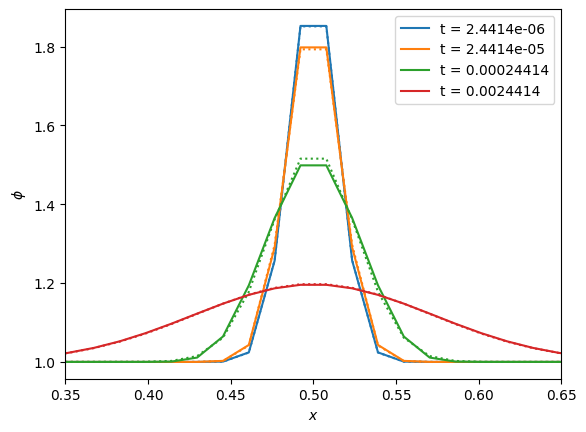

In [6]:
fig, ax = plt.subplots()

color = 0
for n in [0.01, 0.1, 1, 10]:
    g = diffuse_explicit(nx, k, C, n * t_diffuse, gaussian_ic)
    phi_analytic = gaussian_ic(g, k, t=n*t_diffuse)
    ax.plot(g.x[g.ilo:g.ihi+1], g.phi[g.ilo:g.ihi+1], label=f"t = {n * t_diffuse:7.5g}", c=f"C{color}")
    ax.plot(g.x[g.ilo:g.ihi+1], phi_analytic[g.ilo:g.ihi+1], ls=":", c=f"C{color}")
    color += 1

ax.set_xlim(0.35, 0.65)
ax.set_xlabel("$x$")
ax.set_ylabel(r"$\phi$")

ax.legend()

## Resolution

Note that it is critical to resolve the initial conditions.  Let's vary resolution to see what happens if we don't.  We'll plot the solution for different numbers of points all at the same time.

Text(0, 0.5, '$\\phi$')

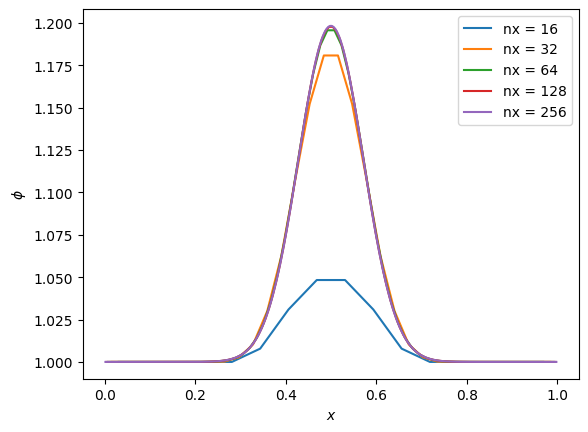

In [7]:
fig, ax = plt.subplots()

for nx in [16, 32, 64, 128, 256]:
    g = diffuse_explicit(nx, k, C, 10 * t_diffuse, gaussian_ic)
    ax.plot(g.x[g.ilo:g.ihi+1], g.phi[g.ilo:g.ihi+1], label=f"nx = {nx}")

ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel(r"$\phi$")


## Exceeding stability

What happens if we exceed the timestep constraint?  Let's find out by setting C = 2.0

Text(0, 0.5, '$\\phi$')

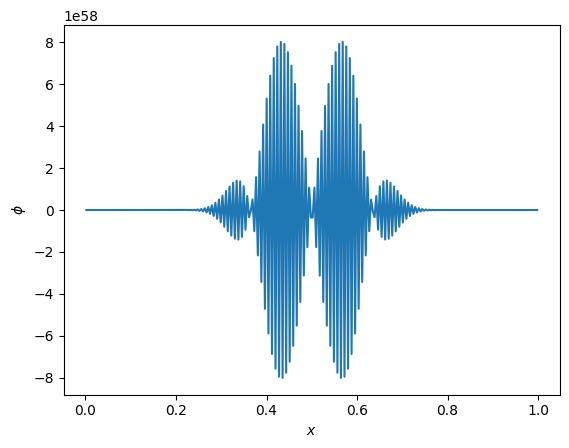

In [8]:
fig, ax = plt.subplots()

nx - 64
C = 2.0

g = diffuse_explicit(nx, k, C, 10 * t_diffuse, gaussian_ic)
ax.plot(g.x[g.ilo:g.ihi+1], g.phi[g.ilo:g.ihi+1])

ax.set_xlabel("$x$")
ax.set_ylabel(r"$\phi$")


Check out that vertical scale!

This is just like what we saw with advection.

## Convergence

How do we converge?

This is a bit trickier than our advection / elliptic cases, since now the truncation error is $\sim \mathcal{O}(\Delta t) + \mathcal{O}(\Delta x^2)$.  Note however, that our timestep is $\Delta t \sim \Delta x^2$, so we should still expect second order convergence as we increase the number of grid points.

In [9]:
nx_reference = 64
t_diffuse = (1.0/nx_reference)**2 / k

Text(0, 0.5, 'absolute error')

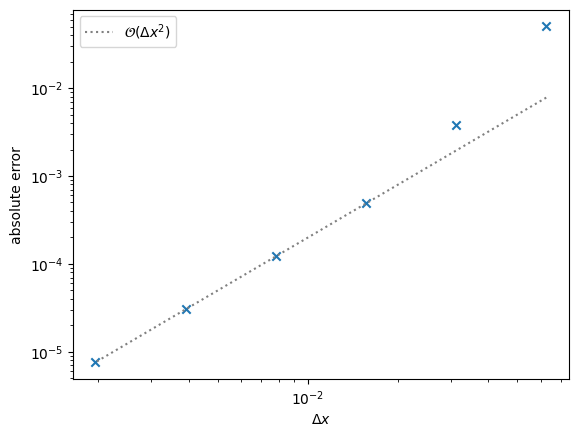

In [10]:
fig, ax = plt.subplots()

Ns = [16, 32, 64, 128, 256, 512]
dxs = []
errors = []

tmax = 10 * t_diffuse
C = 0.8

for nx in Ns:
    g = diffuse_explicit(nx, k, C, tmax, gaussian_ic)
    phi_analytic = gaussian_ic(g, k, t=tmax)
    dxs.append(g.dx)
    errors.append(g.norm(g.phi - phi_analytic))
    
ax.scatter(dxs, errors, marker="x")

ideal = errors[-1] * np.array(dxs)**2 / dxs[-1]**2

ax.plot(dxs, ideal, color="0.5", ls=":", label=r"$\mathcal{O}(\Delta x^2)$")

ax.legend()

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel(r"$\Delta x$")
ax.set_ylabel("absolute error")

Here we see that we attain the expected $\mathcal{O}(\Delta x^2)$ convergence.  For coarse resolution, the fact that we are not really resolving the initial conditions leads to the large errors.